## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

## System

In [26]:
# System parameters (chosen for simplicity)
charging_rate = 0.5    # Influence of charging power on charge level
discharge_rate = 0.1   # Influence of self-discharge on charge level
temperature_rise = 0.05  # Influence of charging power on temperature rise
cooling_rate = 0.02    # Cooling rate of the battery (temperature dissipation)

n = 2  # Two states: charge and temperature
m = 1  # One control input: charging power

# MPC parameters
N = 5    # Horizon length
Q = np.diag([10, 1])  # Cost on charge and temperature
R = 0.5 * np.eye(m)  # Cost on input (charging power)
sim_time = 30
x0 = np.array([[0.2], [25]])  # Initial state: charge 20%, temperature 25°C
x_ref = np.array([[0.8], [30]])  # Desired state: charge 80%, temperature 30°C

# Constraints
u_min, u_max = 0, 1  # Min and max charging power (0W to 1W)
x_min, x_max = 0, 1   # Charge level constraints (0 to 1)
temp_max = 40         # Max temperature constraint (40°C)

# Disturbance setup (random fluctuation in power/temperature)
np.random.seed(42)
disturbance_std = 0 #0.01  # Small disturbances

# State storage
x_hist = [x0]
u_hist = []

In [27]:
# Current state
x = x0.copy()

# MPC loop (control)
for t in range(sim_time):
    # Define optimization variables
    x_var = cp.Variable((n, N+1))  # States over horizon
    u_var = cp.Variable((m, N))    # Inputs over horizon

    # Objective function
    cost = 0
    constraints = [x_var[:, 0] == x.flatten()]  # Initial condition
    for k in range(N):
        cost += cp.quad_form(x_var[:, k] - x_ref.flatten(), Q)  # Track charge and temperature
        cost += cp.quad_form(u_var[:, k], R)  # Penalize large control input

        # Battery dynamics constraints (charge and temperature)
        constraints += [x_var[0, k+1] == x_var[0, k] + charging_rate * u_var[0, k] - discharge_rate * x_var[0, k]]
        constraints += [x_var[1, k+1] == x_var[1, k] + temperature_rise * u_var[0, k] - cooling_rate * x_var[1, k]]

        # Control input constraints (battery charging power)
        constraints += [cp.constraints.NonPos(u_var[:, k] - u_max)]
        constraints += [cp.constraints.NonPos(u_min - u_var[:, k])]

        # State constraints (charge and temperature limits)
        constraints += [cp.constraints.NonPos(x_var[0, k] - x_max)]  # Charge max
        constraints += [cp.constraints.NonPos(x_min - x_var[0, k])]   # Charge min
        constraints += [cp.constraints.NonPos(x_var[1, k] - temp_max)]  # Temperature max

    # Solve the problem
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve()

    # Check if the optimization problem is feasible
    if prob.status == cp.OPTIMAL:
        # Apply first control input
        u = u_var[:, 0].value  # Apply first control action
        u_hist.append(u)

        # Simulate the system with disturbances
        disturbance = np.random.normal(0, disturbance_std, size=(n, 1))  # Disturbance in system
        x = np.array([[x_var[0, 1].value], [x_var[1, 1].value]]) + disturbance  # Update state

        # Store history for plotting
        x_hist.append(x)
    else:
        print(f"Optimization failed at time step {t}.")
        break  # If the problem is not feasible, stop the simulation

    # Apply first control input
    u = u_var[:, 0].value  # Apply first control action
    u_hist.append(u)

    # Simulate the system with disturbances
    disturbance = np.random.normal(0, disturbance_std, size=(n, 1))  # Disturbance in system
    x = np.array([[x_var[0, 1].value], [x_var[1, 1].value]]) + disturbance  # Update state

    # Store history for plotting
    x_hist.append(x)

In [28]:
# Convert to arrays
x_hist = np.hstack(x_hist)
u_hist = np.hstack(u_hist)

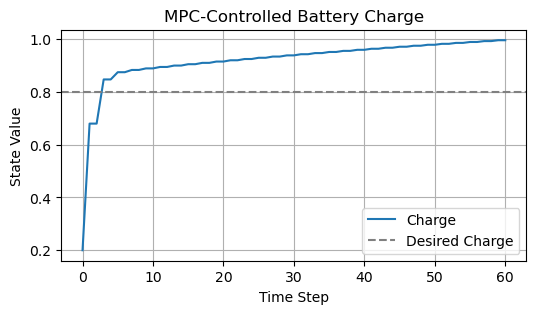

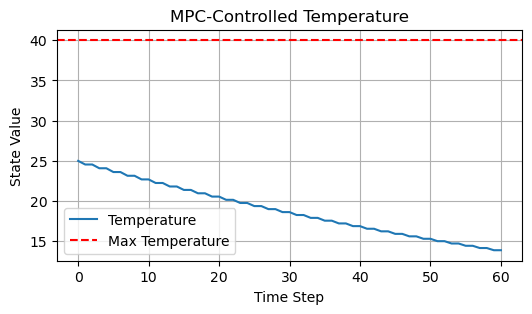

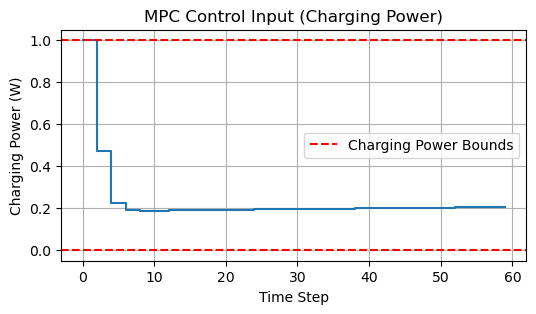

In [29]:
# Plot the results
plt.figure(figsize=(6,3))
plt.plot(x_hist[0, :], label='Charge')
plt.axhline(x_ref[0, 0], linestyle='--', color='gray', label='Desired Charge')
plt.title('MPC-Controlled Battery Charge')
plt.xlabel('Time Step')
plt.ylabel('State Value')
plt.legend()
plt.grid(True)

plt.figure(figsize=(6,3))
plt.plot(x_hist[1, :], label='Temperature')
plt.axhline(temp_max, linestyle='--', color='red', label='Max Temperature')
plt.title('MPC-Controlled Temperature')
plt.xlabel('Time Step')
plt.ylabel('State Value')
plt.legend()
plt.grid(True)

plt.figure(figsize=(6,3))
plt.step(range(len(u_hist)), u_hist, where='post')
plt.axhline(u_max, linestyle='--', color='red', label='Charging Power Bounds')
plt.axhline(u_min, linestyle='--', color='red')
plt.title('MPC Control Input (Charging Power)')
plt.xlabel('Time Step')
plt.ylabel('Charging Power (W)')
plt.legend()
plt.grid(True)